# Modelling Using Term Frequency - Inverse Document Frequency
To create an accurate predictive model which determines how well someone did on their virtual internship there are two potential general methods:
* Using the provided tabular data
* Use a numeric representation of the chat transcripts

Although interpreting the written text is far more difficult than creating a tabular classifier, it has greater overall potential.
This is because the given tabular data does not provide enough information to make an informative decision on how well or badly someone faired.

In [1]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from matplotlib import pyplot as plt
from xgboost import XGBClassifier

## Data Processing
Before we can begin creating models to predict peoples scores we have to ensure that the data is cleaned and interpretable.

The process begins with removing messages sent by the mentor.
These are preset with an average rating of 4 to avoid modifying any average statistics run on the dataset.
However, they do not add any value to the analysis and further skew the mode of the dataset towards the average mean result.

Secondly, we oversample the minority classes which have fewer samples.
This mitigates our models seeing very few highly-rated and low-rated scores, whilst at the same time a very very large number of average ratings (class imbalance).
To finish off we ensure that this though does not happen to the test dataset, as we want to see how it fairs on the actual problem (having duplicates does help).
We utilise random state seeds to ensure that this all happens the exact same way each time.

In [2]:
df = pd.read_csv("../data/data.csv")
df = df[df["RoleName"] != "Mentor"]

In [3]:
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(df[["content"]], df["OutcomeScore"])
x_train, x_test, y_train, y_test = train_test_split(x_resampled["content"], y_resampled, train_size=0.8, random_state=0)
_, x_test, _, y_test = train_test_split(df["content"], df["OutcomeScore"], train_size=0.8, random_state=0) # test on imbalanced data

## Model Training
We will test a variety of models to see how different models fair.
Models include logistic regression (baseline),  naive bays, k-nearest neighbours, decision trees and ensemble models such as random forests and (normal/extreme) gradient boosting.
The selection is designed to accentuate which types of models are most likely to work well for the classification of grades based on sparse text.


To test out our model's several data pipelines are built.
Pipelines are utilised to avoid having to manually run each stage and chain their inputs/outputs together.
Scikit-Learn pipelines assign unique names appropriately to each stage which can be used to reference them and provides a far more quick and elegant approach.

The pipelines all include the following stages:
* Term Frequency-Inverse Document Frequency Vectoriser
* Chi-Squared Feature Selection
* Hyperparameter Optimisation
  * For final models
  * Uses random search


Each models pipeline starts with a TF-IDF vectoriser.
Term Frequency - Inverse Document Frequency (TF-IDF) is used to transform worded textual language into matrices of numbers.
This is necessary because all conventional machine and deep learning classification models (like random forests and neural nets) optimisation routines are designed to process numeric vectors.
Term Frequency - Inverse Document Frequency (TF-IDF) models provide a standard way to go from text to a numeric vector representation of data.
This works by first calculating the number of times each word is used globally (in every document from the text corpus combined) and in each separate document.
The fraction is essentially a weighting of the importance of the word.
This is because words which are frequently used across the board are very unlikely to be useful (common stop words like a, the and to are obvious examples) whereas those used frequently in a select few documents should convey some unique insight.


Although the raw TF-IDF data is useful, there are far too many feature columns to process.
This causes model training to take increasingly large amounts of time.
It also causes some models to either be virtually impossible to train with commonplace hardware and prohibits certain models like gradient boosted ensembles from working well as the data is extremely sparse.
To overcome training and optimisation problems in a relatively short constrained timeframe, we can use the Chi-Squared metric for feature importance and extract the top 2000 features.


Upon first tests, all models go through a hyperparameter optimisation process.
Instead of tuning all hyperparameters, a small selection are chosen per model which either alters how the models function (e.g. optimisation routines) or how conservative they are (e.g. max depth).
Hyperparameter values are randomly selected within their specified range and in the end to the combination which produces the highest weighted f1 score is chosen.
F1 scores are prefered over accuracy simple to avoid situations where either precision or recall is high whilst the other low.
Due to the large computational and time cost in hyperparameter selection, the process is the only rerun for models where it resulted in sizable improvements (based on a further evaluation) or where considerably different to default parameters are chosen.
This is the case for the baseline logistic regression model.
Other optimisation routines are commented out and the basic pipeline is selected instead.


To ensure we find a model which will fair well on real data we use 5-Fold cross-validation when doing our random hyperparameter search.
This statistically ensures that the results are sound and not simply due to overfitting or a randomly easy/hard dataset (for example one with very few examples of high scoring messages will struggle on the test set).


The most important models which are the most likely to perform well are:
* Logistic Regression - Baseline
* Random Forests - Ensemble of Decision Trees
* Extreme Gradient Boosting - Stochastic Gradient Boosted Ensemble of Decision Trees

In [4]:
# baseline_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), LogisticRegression(random_state=0, solver="newton-cg", max_iter=500))

baseline_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        LogisticRegression(random_state=0, solver="lbfgs", penalty="none", max_iter=500),
        {
#             "solver": ["newton-cg", "lbfgs"], # newton-cg offers most relaible convergence
#             "penalty": ["l1", "l2", "elasticnet", "none"], # penalty causes significant performance loss
            "tol": loguniform(1e-5, 1e-3),
#             "C": loguniform(1e-5, 100) # comment out if using no penalty
        },
        n_jobs=3, n_iter=50, cv=5,
        scoring="f1_weighted"
    ),
)

baseline_clf.fit(x_train, y_train);
# baseline_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), baseline_clf["randomizedsearchcv"].best_estimator_)
baseline_clf["randomizedsearchcv"].best_params_

C:\Users\kamwi\miniconda3\envs\vi\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'tol': 0.00013065565828868157}

In [5]:
# naive_bayes_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=1000), MultinomialNB())

naive_bayes_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        MultinomialNB(),
        {
            "alpha": uniform(0, 3),
            "fit_prior": [True, False]
        },
        n_jobs=3, n_iter=100, cv=5,
        scoring="f1_weighted"
    )
)

naive_bayes_clf.fit(x_train, y_train);
naive_bayes_clf["randomizedsearchcv"].best_params_

{'alpha': 0.0061777034624870275, 'fit_prior': True}

In [6]:
# k_nearest_neighbors_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), KNeighborsClassifier())

k_nearest_neighbors_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        KNeighborsClassifier(),
        {
            "n_neighbors": [5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan", "minkowski"]
        },
        n_jobs=3, n_iter=100, cv=5,
        scoring="f1_weighted"
    )
)

k_nearest_neighbors_clf.fit(x_train, y_train);
k_nearest_neighbors_clf["randomizedsearchcv"].best_params_

C:\Users\kamwi\miniconda3\envs\vi\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}

In [7]:
# decision_tree_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=1000), DecisionTreeClassifier(random_state=0))

decision_tree_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        RandomForestClassifier(random_state=0),
        {
            "criterion": ["gini", "entropy"],
#             "max_depth": [None, 5, 10, 50, 100], # max_depth always best none
            "min_samples_split": [2], # randint(2, 5), # min samples leaf always 2
            "min_samples_leaf": [2] # randint(2, 5) # min samples split always 2
        },
        n_jobs=3, n_iter=100, cv=5,
        scoring="f1_weighted"
    )
)

decision_tree_clf.fit(x_train, y_train);
decision_tree_clf["randomizedsearchcv"].best_params_

C:\Users\kamwi\miniconda3\envs\vi\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'entropy'}

In [8]:
# random_forest_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=1000), RandomForestClassifier(random_state=0))

random_forest_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        RandomForestClassifier(random_state=0),
        {
            "n_estimators": randint(2, 100),
#             "max_depth": [None, 5, 10, 50, 100], # max_depth always best none
            "min_samples_split": [2], # randint(2, 5), # min samples leaf always 2
            "min_samples_leaf": [2] # randint(2, 5) # min samples split always 2
        },
        n_jobs=3, n_iter=100, cv=5,
        scoring="f1_weighted"
    )
)

random_forest_clf.fit(x_train, y_train);
random_forest_clf["randomizedsearchcv"].best_params_

{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 99}

In [9]:
gradient_boosted_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), GradientBoostingClassifier(n_estimators=10, max_features=200, max_depth=200, random_state=0))
gradient_boosted_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('selectkbest',
                 SelectKBest(k=2000,
                             score_func=<function chi2 at 0x0000023C723F4E58>)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=200, max_features=200,
                                            n_estimators=10, random_state=0))])

In [10]:
# xg_boosted_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), XGBClassifier(use_label_encoder=False))

xg_boosted_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        XGBClassifier(random_state=0, use_label_encoder=False),
        {
            "max_depth": [None, 5, 10, 50, 100],
            "gamma": randint(0, 5),
            "eta": uniform(0, 1),
            "min_child_weight": uniform(0, 2),
            "max_delta_step": randint(0, 5)
        },
        n_jobs=2, n_iter=100, cv=5,
        scoring="f1_weighted"
    )
)

xg_boosted_clf.fit(x_train, y_train)
xg_boosted_clf["randomizedsearchcv"].best_params_

C:\Users\kamwi\miniconda3\envs\vi\lib\site-packages\cupy\_environment.py:214: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


[04:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'eta': 0.24228681314990175,
 'gamma': 0,
 'max_delta_step': 0,
 'max_depth': 100,
 'min_child_weight': 0.46629165295532604}

## Evaluation
To evaluate how good our models are we will start by formulating a baseline estimate of how good a basic logistic regression model performs.
We will look at the F1 score (which weighs precision and recall) and plot the confusion matrix.
This will be repeated for each additional model.

In [11]:
def evaluate_model(model_pipeline):
    predictions = model_pipeline.predict(x_test)
    f1 = f1_score(y_test, predictions, average="weighted")
    report = classification_report(y_test, predictions)
    
    plot_confusion_matrix(model_pipeline, x_test, y_test);
    
    return f1, report

## Logistic Regression Baseline

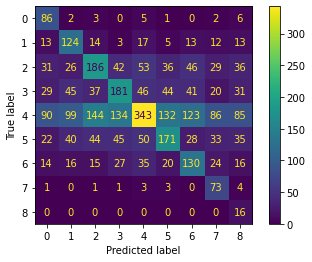

In [12]:
f1, report = evaluate_model(baseline_clf)

In [13]:
f1

0.3932924201680839

In [14]:
print(report)

              precision    recall  f1-score   support

           0       0.30      0.82      0.44       105
           1       0.35      0.58      0.44       214
           2       0.42      0.38      0.40       485
           3       0.42      0.38      0.40       474
           4       0.62      0.28      0.38      1236
           5       0.42      0.37      0.39       468
           6       0.34      0.44      0.38       297
           7       0.26      0.85      0.40        86
           8       0.07      1.00      0.12        16

    accuracy                           0.39      3381
   macro avg       0.36      0.57      0.37      3381
weighted avg       0.47      0.39      0.39      3381



## Naive Bayes

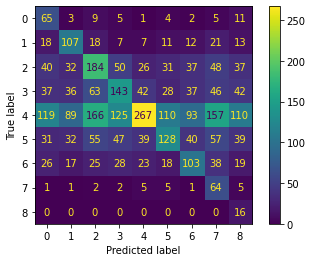

In [15]:
f1, report = evaluate_model(naive_bayes_clf)

In [16]:
f1

0.3311276478440187

In [17]:
print(report)

              precision    recall  f1-score   support

           0       0.19      0.62      0.29       105
           1       0.34      0.50      0.40       214
           2       0.35      0.38      0.37       485
           3       0.35      0.30      0.32       474
           4       0.65      0.22      0.32      1236
           5       0.38      0.27      0.32       468
           6       0.32      0.35      0.33       297
           7       0.15      0.74      0.25        86
           8       0.05      1.00      0.10        16

    accuracy                           0.32      3381
   macro avg       0.31      0.49      0.30      3381
weighted avg       0.45      0.32      0.33      3381



## K-Nearest Neighbors

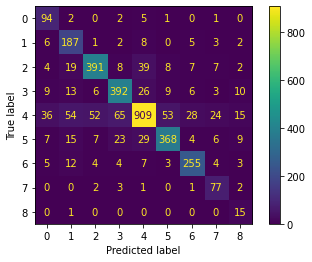

In [18]:
f1, report = evaluate_model(k_nearest_neighbors_clf)

In [19]:
f1

0.7998380760965783

In [20]:
print(report)

              precision    recall  f1-score   support

           0       0.58      0.90      0.71       105
           1       0.62      0.87      0.72       214
           2       0.84      0.81      0.82       485
           3       0.79      0.83      0.81       474
           4       0.89      0.74      0.80      1236
           5       0.83      0.79      0.81       468
           6       0.83      0.86      0.85       297
           7       0.62      0.90      0.73        86
           8       0.26      0.94      0.41        16

    accuracy                           0.80      3381
   macro avg       0.70      0.85      0.74      3381
weighted avg       0.82      0.80      0.80      3381



## Decision Trees

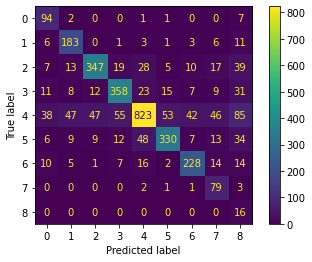

In [21]:
f1, report = evaluate_model(decision_tree_clf)

In [22]:
f1

0.7512453927280456

In [23]:
print(report)

              precision    recall  f1-score   support

           0       0.55      0.90      0.68       105
           1       0.69      0.86      0.76       214
           2       0.83      0.72      0.77       485
           3       0.79      0.76      0.77       474
           4       0.87      0.67      0.76      1236
           5       0.81      0.71      0.75       468
           6       0.77      0.77      0.77       297
           7       0.43      0.92      0.59        86
           8       0.07      1.00      0.12        16

    accuracy                           0.73      3381
   macro avg       0.64      0.81      0.66      3381
weighted avg       0.80      0.73      0.75      3381



## Random Forests

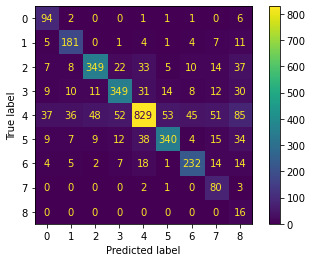

In [24]:
f1, report = evaluate_model(random_forest_clf)

In [25]:
f1

0.7545843505935956

In [26]:
print(report)

              precision    recall  f1-score   support

           0       0.57      0.90      0.70       105
           1       0.73      0.85      0.78       214
           2       0.83      0.72      0.77       485
           3       0.79      0.74      0.76       474
           4       0.87      0.67      0.76      1236
           5       0.82      0.73      0.77       468
           6       0.76      0.78      0.77       297
           7       0.41      0.93      0.57        86
           8       0.07      1.00      0.13        16

    accuracy                           0.73      3381
   macro avg       0.65      0.81      0.67      3381
weighted avg       0.80      0.73      0.75      3381



## Gradient Boosting

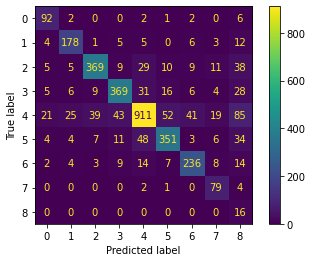

In [27]:
f1, report = evaluate_model(gradient_boosted_clf)

In [28]:
f1

0.7918239648603528

In [29]:
print(report)

              precision    recall  f1-score   support

           0       0.69      0.88      0.77       105
           1       0.79      0.83      0.81       214
           2       0.86      0.76      0.81       485
           3       0.83      0.78      0.80       474
           4       0.87      0.74      0.80      1236
           5       0.80      0.75      0.77       468
           6       0.78      0.79      0.79       297
           7       0.61      0.92      0.73        86
           8       0.07      1.00      0.13        16

    accuracy                           0.77      3381
   macro avg       0.70      0.83      0.71      3381
weighted avg       0.83      0.77      0.79      3381



## Extreme Gradient Boosting

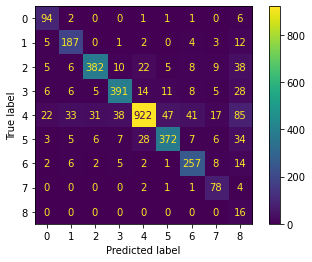

In [30]:
f1, report = evaluate_model(xg_boosted_clf)

In [31]:
f1

0.822168843306187

In [32]:
print(report)

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       105
           1       0.76      0.87      0.81       214
           2       0.90      0.79      0.84       485
           3       0.87      0.82      0.84       474
           4       0.93      0.75      0.83      1236
           5       0.85      0.79      0.82       468
           6       0.79      0.87      0.82       297
           7       0.62      0.91      0.74        86
           8       0.07      1.00      0.13        16

    accuracy                           0.80      3381
   macro avg       0.72      0.85      0.73      3381
weighted avg       0.86      0.80      0.82      3381



## Performance Evaluation
Out of all the models we can clearly see that our models all overall have higher precision scores than recall scores.
This can be seen at the bottom of each classification reports, which show a variety of metrics (all usually with similar scores).
For the most part, the recall scores tend to around 0.06-0.10 or in other words 6-10% lower than precision for all models apart from k-nearest neighbours.
For robustness though the F1 score shall be used to decipher which models perform best.


We can empirically see that basic logistic regression and naive Bayes models perform at around ~40 accuracies.
This makes logical sense as these are the simpler models, so they are likely underfitting the data.
The confusion matrix has both a bright diagonal and horizontal line.
The horizontal line at four indicates that average scores are being predicted more than anything else, despite the fact that we are working with an already rebalanced dataset where the minority classes have been oversampled.
Although it is not shown here, substituting the oversampled training dataset with the original unaltered one will result in this to an extreme extent where the number four is almost the only number predicted.


Although a recurring pattern of far-too-many average fours being predicted is not visible in the other models, we can still see this to varying extents.
We can see that outcome scores with fewer samples like 8 have across-the-board concerningly low precision.
This is caused by the models predicting numerous false positives.
Although the models effectively predict messages with eights as eights, they tend to predict a variety of other outcome scores as also eight.
The problem occurs for zeros, sevens and eights and is most likely a symptom of having very few unique examples of these classes.
Hence, to greatly improve model performances across the board more data would be necessary.


The best performing model is extreme gradient boosting at 82% F1, closely followed by standard gradient boosting and the k-nearest neighbours classifier ~79%.
These models tend to output F1 scores per label around 10% higher than most other models.
Yet, they still tend to struggle with the minority classes.

## Taking Models Further
Although there relatively few individuals in the dataset, we can use these models for an individuals score by either averaging the results from the model or creating another model which acts like an ensemble processing these models predictions.
The latter option would quite likely perform better as it may be able to avoid problems with introductory messages pulling down the overall scores.

This is a far better approach than creating a model to process messages composed of concatenated text from all of a users messages for three reasons:
* Language models typically struggle with long sentences
* There are far more messages than users and machine learning models work well with larger datasets
* We can easily re-apply our models and get solid results for the real internships with our existing models (without major refactor/extensions)